# HRV data 
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr> 

In [2]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

import sys
sys.path.append('/volper/users/alayaelm/Documents/git/wasslsp/src/')

from src.utils import *
from src.kernels import Kernel

init_notebook_mode(connected=True) ## plotly init

import os
path_data = '/volper/users/alayaelm/Documents/git/wasslsp/data/'

In [3]:
df_babyecg = pd.read_csv(path_data+'BabyECG.csv')
df_babyecg.head(), df_babyecg.shape

(   Unnamed: 0    x
 0           1  129
 1           2  130
 2           3  123
 3           4  126
 4           5  125,
 (2048, 2))

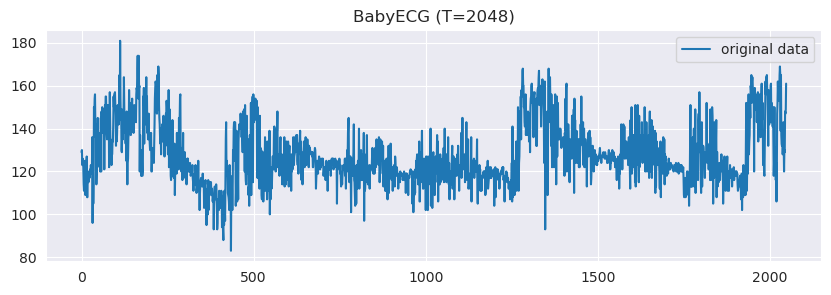

In [4]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(df_babyecg['x'], label="original data")
# plt.plot(df_babyecg['x'].diff(), label="diff")
plt.legend()
plt.title("BabyECG (T=2048)")
plt.show()

In [5]:
def replication_ECG(data=None, sigma=1., d=1, n_replications=1):
    """
    Replication genearating procedure of HRV data
    """
    T = data.shape[0]
    
    X_tvar_2 = np.zeros(T)
    X_tvar_2_replications = np.zeros((n_replications, T))

    X_dict = {}
    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T), scale=sigma)
        X = np.zeros((T,d))
        while t <= T-1 :
            X_tvar_2[t] = df_babyecg['x'].values[t] + epsilon[t]
            X[t] = [X_tvar_2[t-1]]
            t += 1
        
        X_dict[str(replication)] = X
        X_tvar_2_replications[replication] = X_tvar_2
        
    return X_tvar_2_replications

In [6]:
sns.set(style="darkgrid")

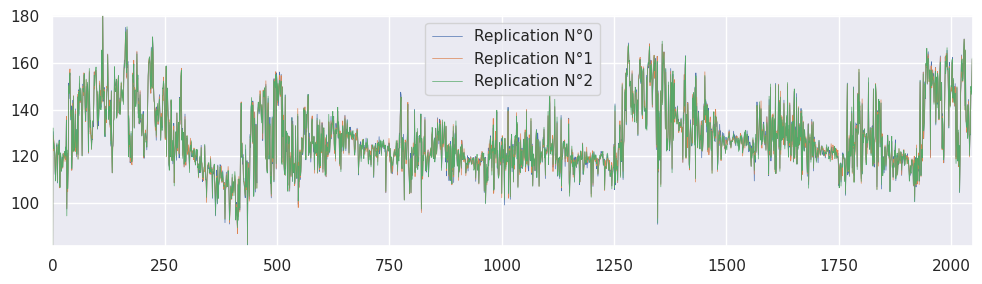

In [7]:
plt.rcParams["figure.figsize"] = (10,3)

T = df_babyecg['x'].shape[0]
u_var = np.linspace(0., 1., T)
sigma = 1.
n_replications = 3

X_tvar_2_replications = replication_ECG(
    data=df_babyecg['x'], sigma=sigma, n_replications=n_replications
)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=.5, label='Replication n°' f'{replication}')
    plt.ylim(min(X_tvar_2_replications[replication][1:,]), max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    
    plt.grid(True)
    plt.legend()
    
plt.tight_layout()
plt.savefig(f"3 replications of HRV dataset sigma={sigma}.pdf", dpi=300)
plt.show()

# NW Conditional CDF

In [8]:
times_t = [1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240]
times_T = [T]
times_sigma = [1, 0.1, 0.01, 0.001, 0.0001]
n_replications = [1000, 1500, 2000]
d = 1


In [9]:
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
bandwidth = lambda_ * ( T **(-xi) )
uvals = np.array(times_t) / T
uvals

array([0.53710938, 0.546875  , 0.55664062, 0.56640625, 0.57617188,
       0.5859375 , 0.59570312, 0.60546875])

In [10]:
mask = []
for val in uvals:
    bool_ = (val >= bandwidth) and (val <= 1-bandwidth)
    mask.append(bool_)

mask

[np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_]

In [11]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

for sigma_ in times_sigma:
    X_dict[f"sigma:{sigma_}"] = {}
    
    for rep in n_replications:
        X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
        X_dict[f"sigma:{sigma_}_rep:{rep}"] = {}


In [12]:
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [13]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                t = 1
                epsilon = np.random.normal(size=T, scale=sigma_)
                X = np.zeros((T, d))
                X_tvar_2_T = np.zeros(T)
                
                while t <= T-1:
                    X_tvar_2_T[t] = df_babyecg['x'].values[t] + epsilon[t]
                    X[t] = [X_tvar_2_T[t-1]]
                    t += 1

                X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication] = X_tvar_2_T
                X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)] = X


In [14]:
X_tvar_2 = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


In [15]:

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for rep in n_replications:
        for replication in range(rep):
            for sigma_ in times_sigma:
                z = X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication][t-1]
                X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(z)


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.array(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [16]:
plt.rcParams["figure.figsize"] = (5, 4)

norm_X_tvar_2 = {}
for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            norm_X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


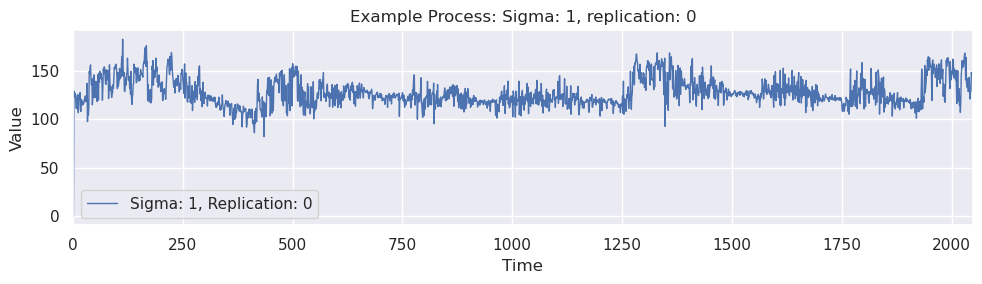

In [17]:
sigma_example = times_sigma[0]  
rep_example = n_replications[0]  

example_process_key = f"sigma:{sigma_example}_rep:{rep_example}"
example_replication = "0"  

time_series = X_dict[example_process_key][example_replication]

plt.rcParams["figure.figsize"] = (10,3)
plt.plot(time_series, label=f"Sigma: {sigma_example}, Replication: {example_replication}", lw=1)
plt.title(f"Example Process: Sigma: {sigma_example}, replication: {example_replication}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xlim(0, T)
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

# space_kernel = "gaussian"; time_kernel = "uniform"

In [18]:
space_kernel = "gaussian"  # "silverman"
time_kernel = "uniform"  # "tricube"
xi = 0.4 / (2 * (d + 1))
lambda_ = 1 / 12

T = df_babyecg['x'].shape[0]
gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}

for sigma_ in times_sigma:
    bandwidth = lambda_ * (T ** (-xi))
    gaussian_kernel[f"sigma:{sigma_}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)


In [19]:
gaussian_kernel

{'sigma:1': Kernel(T=2048, bandwidth=0.03887637464736697, time_kernel='uniform'),
 'sigma:0.1': Kernel(T=2048, bandwidth=0.03887637464736697, time_kernel='uniform'),
 'sigma:0.01': Kernel(T=2048, bandwidth=0.03887637464736697, time_kernel='uniform'),
 'sigma:0.001': Kernel(T=2048, bandwidth=0.03887637464736697, time_kernel='uniform'),
 'sigma:0.0001': Kernel(T=2048, bandwidth=0.03887637464736697, time_kernel='uniform')}

In [20]:
for rep in n_replications:
    for replication in range(rep):
        for t in times_t:
            for sigma_ in times_sigma:
                gaussian_weights[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = \
                gaussian_kernel[f"sigma:{sigma_}"].fit(X_dict[f"sigma:{sigma_}_rep:{rep}"][str(replication)], t)


In [21]:
n_replications

[1000, 1500, 2000]

In [22]:
gaussian_weights_tensor = {}  

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):
        for rep in n_replications:
            gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"] = {}

for i_t in range(len(times_t)):
    for i_sigma in range(len(times_sigma)):  
        for rep in n_replications:
            for replication in range(rep):
                gaussian_weights_tensor[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)] = \
                gaussian_weights[f"t:{times_t[i_t]}_sigma:{times_sigma[i_sigma]}_rep:{rep}"][str(replication)]


In [23]:
empirical_cds = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_sigma:{sigma_}_rep:{rep}"])


In [24]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [25]:
x_rep = {} 
y_rep = {} 
wasserstein_distances = {}

for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = np.zeros((rep, T))
            wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = {}


for rep in n_replications:
    for replication in range(rep): 
        for t in times_t:
            for sigma_ in times_sigma:
                y, x = eval_univariate(
                    X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication], 
                    gaussian_weights_tensor[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )
                
                x_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = x
                y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"][replication] = y
                
                distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"sigma:{sigma_}_rep:{rep}"][replication]))
                wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)] = distance


In [26]:
wass_distances_all_replications = {}


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = []


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            for replication in range(rep):
                
                wass_distances_all_replications[f"t:{t}_sigma:{sigma_}_rep:{rep}"].append(
                    wasserstein_distances[f"t:{t}_sigma:{sigma_}_rep:{rep}"][str(replication)]
                )


In [27]:
plt.rcParams["figure.figsize"] = (10, 3)
wass_distances_empirical_meanNW = {}


for t in times_t:
    for sigma_ in times_sigma:
        for rep in n_replications:
            
            wass_distances_empirical_meanNW[f"t:{t}_sigma:{sigma_}_rep:{rep}"] = wasserstein_distance(
                empirical_cds[f"t:{t}_sigma:{sigma_}_rep:{rep}"], y_rep[f"t:{t}_sigma:{sigma_}_rep:{rep}"].mean(axis=0)
            )


In [28]:
wass_distances_empirical_meanNW

{'t:1100_sigma:1_rep:1000': np.float64(0.3921759766439368),
 't:1100_sigma:1_rep:1500': np.float64(0.3947534937815683),
 't:1100_sigma:1_rep:2000': np.float64(0.3927177767987511),
 't:1100_sigma:0.1_rep:1000': np.float64(0.4216776357684751),
 't:1100_sigma:0.1_rep:1500': np.float64(0.42186440644003786),
 't:1100_sigma:0.1_rep:2000': np.float64(0.4215973694591741),
 't:1100_sigma:0.01_rep:1000': np.float64(0.437965250178426),
 't:1100_sigma:0.01_rep:1500': np.float64(0.4375365396550452),
 't:1100_sigma:0.01_rep:2000': np.float64(0.4378665218784502),
 't:1100_sigma:0.001_rep:1000': np.float64(0.438395761259934),
 't:1100_sigma:0.001_rep:1500': np.float64(0.43811828714279016),
 't:1100_sigma:0.001_rep:2000': np.float64(0.4382960469265761),
 't:1100_sigma:0.0001_rep:1000': np.float64(0.4384450258232058),
 't:1100_sigma:0.0001_rep:1500': np.float64(0.4380835637596172),
 't:1100_sigma:0.0001_rep:2000': np.float64(0.43837470928579303),
 't:1120_sigma:1_rep:1000': np.float64(0.2426911047158239

In [29]:
wass_times_t = {}
for t in times_t:
    for rep in n_replications:
        wass_times_t[f"t:{t}_rep:{rep}"] = []
        for sigma_ in times_sigma:
            key = f"t:{t}_sigma:{sigma_}_rep:{rep}"
            distance = wass_distances_empirical_meanNW.get(key, 0)
            wass_times_t[f"t:{t}_rep:{rep}"].append(distance)


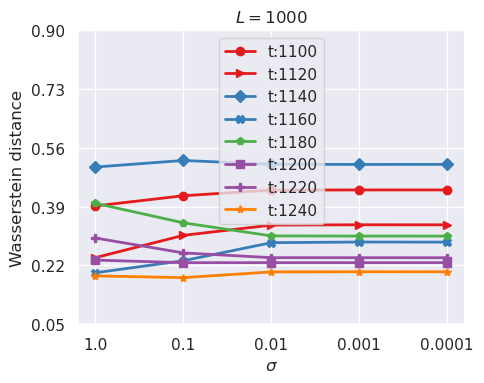

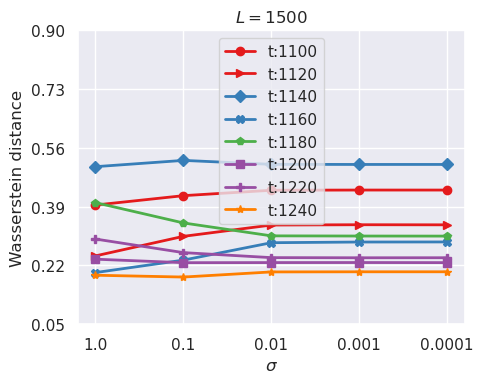

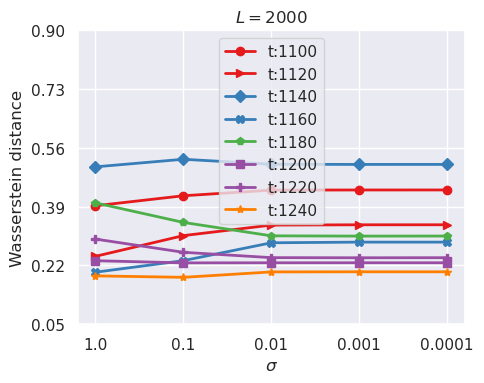

In [47]:

plt.rcParams["figure.figsize"] = (5, 4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*']
times_sigma_cat = [r'1.0', r'0.1', r'0.01', r'0.001', r'0.0001']
#times_sigma_inv_cat = [f'${1/sigma:.2f}$' for sigma in times_sigma]

for rep in n_replications:
    plt.figure()
    for i, t in enumerate(times_t):
        plt.plot(times_sigma_cat, wass_times_t[f"t:{t}_rep:{rep}"], label=f"t:{t}", color=colors[i % len(colors)], marker=markers[i % len(markers)], markersize=6, lw=2)

    y_ticks = np.linspace(0.05, .9, 6)
    plt.yticks(y_ticks)
    plt.xlabel(r'$\sigma$')
    # plt.xscale('symlog')
    plt.ylabel("Wasserstein distance")
    plt.title(f"$L={rep}$")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"W1_BabyECG_time-uniform_space-gaussian_rep_{rep}.png", dpi=150)
    plt.show()
